<a href="https://colab.research.google.com/github/kenneth-craig/academyPub/blob/main/ARIMA-annual-water-usage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ARIMA Sample for Baltimore Water Usage (1885-1963)

In [1]:
# Install latest statsmodel library v0.13
!pip install -U statsmodels

     |████████████████████████████████| 9.8 MB 4.4 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [2]:
# Easiest Way to get file uploaded to Google Colab environment
from google.colab import files
file = files.upload()

Saving annual-water-usage.csv to annual-water-usage.csv


# End To End ARIMA Sample Using Boston Armed Robery Dataset - Ch30
**Problem Description** - Ch 31.2

**Test Harness** - Ch 31.3

**Persistence Model for Comparison Purposes** - Ch 31.4

**Data Analysis** - Ch 31.5

**ARIMA Model** - Ch 31.6

**Model Validation** - Ch 31.7

# Problem Description
- Predict annual water usage in Baltimore, USA
- The dataset provides annual water usage in Baltimore from 1885 to 1963, or 79 years of data
- The values are in the units of litres per capita per day and there are 79 observations
- The problem will use Rolling Forecast type model


# Test Harness
**Evaluation Method**
- Evaluate the performance of predictions using Root Mean Squared (RMSE) - This will give more weight to predictions that are grossly wrong and will have same unit as original data
- Any transformations to the data (e.g. box-cox) must be reversed before RMSE is calculated and calculated & reported to make the performance between different mothods directly comparable

**Test Strategy**
- The dataset is not current therefore 10 years (10 records) of data will be withheld to validate for the final model.
- Will be evaluated using walk-forward validation i.e. one-step forecasts are needed given all available data
- Walk forward validation will work as follows:

 - 50% of data will be held back for training the model
 - Remaining 50% of the dataset will be iterated and used to test the model
- For each step in the Test dataset:
 - A model will be trained
 - A one-step prediction made and the prediction stored for later evaluation
 - The actual observation from the test dataset will be added to the training dataset for the next iteration
- the redictions made during the iteration of the test dataset will be evaluated and RMSE score reported
- Given the small size of the dataset we will allow a model to be re-trained given all available data prior to each prediction

In [4]:
# Separate out Validation dataset
import pandas as pd

series = pd.read_csv('annual-water-usage.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
print(series.head())
split_point = len(series) - 10
dev_water, oot_water = series[0:split_point], series[split_point:]
print('Development %d, Validation %d' % (len(dev_water), len(oot_water)))
dev_water.to_csv('dev_water.csv')
oot_water.to_csv('oot_water.csv')


Year
1885-01-01    356
1886-01-01    386
1887-01-01    397
1888-01-01    397
1889-01-01    413
Name: Water, dtype: int64
Development 69, Validation 10


# Persistence Model for Comparison Purproses

In [ ]:
# simple persistence model for annual water usage
import pandas as pd
from sklearn.metrics import mean_squared_error
from math import sqrt

# Load dataset
series = pd.read_csv('dev_water.csv', header=0, index_col=0, parse_dates=True, squeeze=True)

# RMSE Performance Measure & Walk-Forward Validation will be used for Model Evaluation
# Prepare Data
X = series.values.astype('float32')
train_size = int(len(X) * 0.50)
train,test = X[0:train_size], X[train_size:]

# Walk Forward validation
# Create History for Training data
history = [x for x in train]
# Predict result using Persistence Model
predictions = list()
for i in range(len(test)):
  # Predict
  yhat = history[-1]
  predictions.append(yhat)
  # Add observation to history
  obs = test[i]
  history.append(obs)
  print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
# Report Performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

# Conclusion: An RMSE value of 21.975 means that on average the model was wrong by about 22 litres per capita per day for each prediction made

**Conclusion**
- An RMSE value of 21.975 means that on average the model was wrong by about 22 litres per capita per day for each prediction made

# Data Analysis
1) Summary Statistics

2) Line Plot

3) Density Plot

4) Box & Whisker Plot comparing Annual Data Trends

5) Stationary Data test

6) ACF & PACF Auto-Correlation Plots

count     69.000000
mean     500.478261
std       73.901685
min      344.000000
25%      458.000000
50%      492.000000
75%      538.000000
max      662.000000
Name: Water, dtype: float64


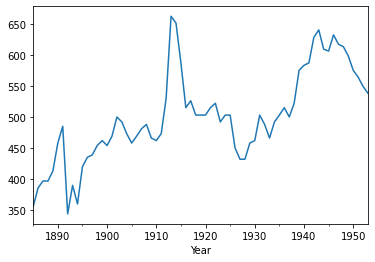

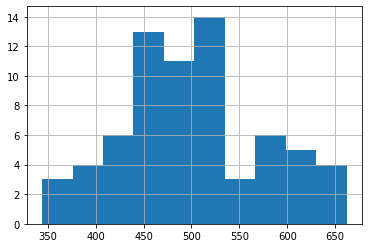

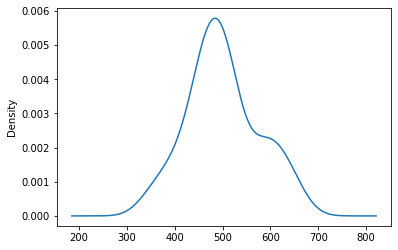

In [19]:
# Summary Statistics of Time Series
import pandas as pd
from matplotlib import pyplot

series = pd.read_csv('dev_water.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
print(series.describe())
# Observations: The standard deviation and percentiles suggests a reasonably tight spread around the mean

# Line plot
series.plot()
pyplot.show()
# Observations:
# There looks to be an increased water usage over time
# No obvious outliers although there are some large fluctuations over time
# Small downward trend in the last few years
# May be some benefit in explicitly modelling the trend component and removing it.
# Also consider differencing one or two levels in order to make the series stationary

# Density plot
series.hist()
pyplot.show()

# Histogram plot
series.plot(kind='kde')
pyplot.show()

# Plot Observations:
# The plot is not Gaussian but is pretty close
# The distribution has a long right tail and may suggest an exponential or a double gaussian
# May benefit exploring some power transforms of the data prior to modelling

**Data Analysis Observations**
- The standard deviation and percentiles suggests a reasonably tight spread around the mean

**Line Plot Observations**
- There looks to be an increased water usage over time
- No obvious outliers although there are some large fluctuations over time
- Small downward trend in the last few years
- May be some benefit in explicitly modelling the trend component and removing it.
- Also consider differencing one or two levels in order to make the series stationary

**Density Plot Observations**
- The plot is not Gaussian but is pretty close
- The distribution has a long right tail and may suggest an exponential or a double gaussian
- May benefit exploring some power transforms of the data prior to modelling

**Box & Whisker Plot**

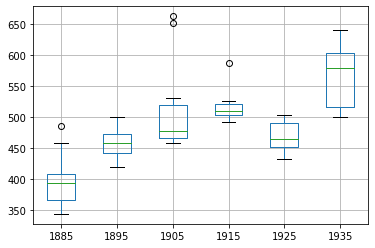

In [22]:
# Box & Whisker Plot
import pandas as pd
from matplotlib import pyplot

# load data
series = pd.read_csv('dev_water.csv', header=0, index_col=0, parse_dates=True, squeeze=True)

# Group the data by every 10 years
groups = series.groupby(pd.Grouper(freq='10YS'))
decades = pd.DataFrame()
for name, group in groups:
  if len(group.values) is 10:
    decades[name.year] = group.values
# Box plot
decades.boxplot()
pyplot.show()

# Observations:
# The median value for each year (green line) may show increasing trend that may not be linear
# Spread (middle 50%) of the data (blue box) does show some variability
# The 2nd to last decade seems to have a lower average consumption, perhaps related to the first world war

**Observations:**
- The median value for each year (green line) may show increasing trend that may not be linear
- Spread (middle 50%) of the data (blue box) does show some variability
- The 2nd to last decade seems to have a lower average consumption, perhaps related to the first world war

**Additional Analysis**
- This yearly view of the data could be persued further by looking at the summary statics for each decade and changes in summary statics for each decade

# ARIMA Model
- Create and Test for Stationary Data
- Augmented Dickey Fuller Test
- ACF & PACF Auto_Correlation Plots
- Manual Prediction
- Grid Search
- Review Residual Errors
- Box-Cox Log Transformed Dataset

ADF Statistic: -6.126719
p-value: 0.000000
Critical Values:
	1%: -3.534
	5%: -2.906
	10%: -2.591


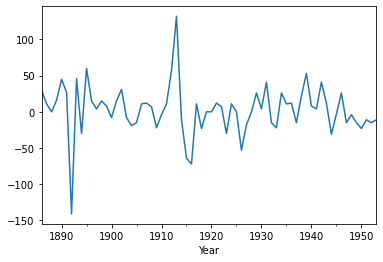

In [26]:
# Create and Test for Stationary Data
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from matplotlib import pyplot

# create differenced series
def difference(dataset):
  diff = list()
  for i in range(1, len(dataset)):
    value = dataset[i] - dataset[i-1]
    diff.append(value)
  return pd.Series(diff)

series = pd.read_csv('dev_water.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
X = series.values.astype('float32')
# difference data
stationary = difference(X)
stationary.index = series.index[1:]
# check if stationary
result = adfuller(stationary)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
  print('\t%s: %.3f' % (key, value))
# plot differenced data
stationary.plot()
pyplot.show()
# save
stationary.to_csv('stationary.csv')
